In [31]:
import numpy as np
import pandas as pd
import math
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes 
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
from matplotlib import rc
import seaborn as sns
import pandas as pd
from scipy import stats
from scipy.optimize import curve_fit
from scipy.integrate import odeint
from scipy.integrate import solve_ivp
from mpl_toolkits.mplot3d import Axes3D
import ternary
import warnings
import random

%matplotlib inline
warnings.filterwarnings('ignore')

# Benthic Parameters

**Coral growth:** $r =  0.04–0.2 yr^{-1}$  *(Fung et al., 2011)*

**Coral mortality:** $mu =  0.02–0.1 yr^{-1}$  *(Fung et al., 2011)*


**Growth rate of macroalgae onto free space:** $gamma = 0.05–0.4 yr^{-1}$ *Fung et al., 2011*

**Macroalge mortality:** $pM =  0.02–1.1 yr^{-1}$ (Used values from *Fung et al., 2011* but formulation from *Cook et al., 2023*)


**Growth rate of turf onto free space:** $beta = 2–20 yr^{-1}$ *(Fung et al., 2011)*

**Turf mortality:** $pT =  0.0–1.0 yr^{-1}$  *(arbitrary)*

**Growth rate of corals onto turf relative to the rate onto free space:** $alpha1 = 0.0-1.0$ *(Fung et al., 2011)*

**Growth rate of macroalgae onto turf relative to the rate onto free space:** $alpha2 = 0–0.9$ *(Fung et al., 2011)*

**Rate of macroalgae overgrowth onto coral relative to the rate onto free space:** $alpha3 = 0–0.9$ *(Fung et al., 2011)*

# Defining ODE & Parameter Ranges

In [32]:
def dNdt(t, N, r, gamma, beta, alpha1, alpha2, alpha3, mu, pM, pT, g1, n, s1, e1, theta1, d1):
    
    C,M,T = N
    
    dC = ((r)*C*(1-C-M-T) + alpha1*r*C*T - alpha3*gamma*C*M - mu*C)*dt
    dM = ((gamma)*M*(1-C-M-T) + alpha2*gamma*T*M + alpha3*gamma*C*M - pM*M)*dt
    dT = ((beta)*T*(1-C-M-T) - alpha1*r*C*T - alpha2*gamma*T*M - pT*T)*dt
    
    return dC, dM, dT

In [33]:
dt = 1
NUMSTEPS = 1000
NUMYEARS = int(NUMSTEPS/dt)
time_points = np.linspace(0, NUMYEARS, NUMSTEPS+1)

C0 = 0.99
M0 = 0.005
T0 = 0.005

r = (0.04 + 0.2)/2 #coral growth
gamma = (0.05 + 0.4)/2 #macro algae growth rate over free space
beta = (2 + 20)/2 #turf growth rate onto free space
alpha1 = 1.0/2 #growth rate of corals onto turf relative to the rate onto free space
alpha2 = 0.9/2 #growth rate of macroalgae onto turf relative to the rate onto free space
alpha3 = 0.9/2 #rate of macroalgal overgrowth onto coral relative to the rate onto free space

#mortality rates
mu = (0.02 + 0.1)/2 #coral death rate
pM = (0.02 + 1.1)/2 #macroalgal death rate
pT = (0 + 1.0)/2 #turf death rate

In [34]:
par_step = 20

r_value = np.linspace(0.04, 0.2, par_step)
r_value = np.round(r_value,4)

gamma_value = np.linspace(0.05, 0.4, par_step)
gamma_value = np.round(gamma_value,4)

beta_value = np.linspace(2, 20, par_step)
beta_value = np.round(beta_value,4)

alpha1_value = np.linspace(0, 1.0, par_step)
alpha1_value = np.round(alpha1_value,4)

alpha2_value = np.linspace(0, 0.9, par_step)
alpha2_value = np.round(alpha2_value,4)

alpha3_value = np.linspace(0, 0.9, par_step)
alpha3_value = np.round(alpha3_value,4)

#mortality rates
mu_value = np.linspace(0.02, 0.1, par_step)
mu_value = np.round(alpha3_value,4)

pM_value = np.linspace(0.02, 1.1, par_step)
pM_value = np.round(alpha3_value,4)

pT_value = np.linspace(0, 1.0, par_step)
pT_value = np.round(alpha3_value,4)

# Defining functions to co-vary parameters with pM (macro mortality)
### For each, I change positions of p1 (parameter 1) and p2 (parameter 2) based on which parameters I co-vary.

In [35]:
# r x pM
def parcross_r_pM(p1_val, p2_val):
    
    outputs = []
    outputs_prime = []

    for p1 in p1_val:

        for p2 in p2_val:

            if (C0 + M0 + T0 <= 1):

                sol = solve_ivp(dNdt, [0,NUMYEARS], [C0, M0, T0], method = 'RK45', 
                                args = (p1, 
                                        gamma, 
                                        beta, 
                                        alpha1, 
                                        alpha2, 
                                        alpha3, 
                                        mu, p2, pT, 
                                        g1, n, s1, e1, theta1, d1), 
                                dense_output=True)
                N = sol.sol(time_points) 

                C_array = N[0,:]
                M_array = N[1,:]
                T_array = N[2,:]

                outputs.append((p1, p2, C_array, M_array, T_array))
                outputs_prime.append((p1, p2, C_array[-1], M_array[-1], T_array[-1]))
    
    df_timeseries = pd.DataFrame(outputs, columns=['p1','p2','C_array','M_array','T_array'])
    df_prime = pd.DataFrame(outputs_prime, columns=['p1','p2','C_prime','M_prime','T_prime'])
    return(df_timeseries, df_prime)


# gamma x pM
def parcross_gamma_pM(p1_val, p2_val):
    
    outputs = []
    outputs_prime = []

    for p1 in p1_val:

        for p2 in p2_val:

            if (C0 + M0 + T0 <= 1):

                sol = solve_ivp(dNdt, [0,NUMYEARS], [C0, M0, T0], method = 'RK45', 
                                args = (r, 
                                        p1, 
                                        beta, 
                                        alpha1, 
                                        alpha2, 
                                        alpha3, 
                                        mu, p2, pT, 
                                        g1, n, s1, e1, theta1, d1), 
                                dense_output=True)
                N = sol.sol(time_points) 

                C_array = N[0,:]
                M_array = N[1,:]
                T_array = N[2,:]

                outputs.append((p1, p2, C_array, M_array, T_array))
                outputs_prime.append((p1, p2, C_array[-1], M_array[-1], T_array[-1]))
    
    df_timeseries = pd.DataFrame(outputs, columns=['p1','p2','C_array','M_array','T_array'])
    df_prime = pd.DataFrame(outputs_prime, columns=['p1','p2','C_prime','M_prime','T_prime'])
    return(df_timeseries, df_prime)


# beta x pM
def parcross_beta_pM(p1_val, p2_val):
    
    outputs = []
    outputs_prime = []

    for p1 in p1_val:

        for p2 in p2_val:

            if (C0 + M0 + T0 <= 1):

                sol = solve_ivp(dNdt, [0,NUMYEARS], [C0, M0, T0], method = 'RK45', 
                                args = (r, 
                                        gamma, 
                                        p1, 
                                        alpha1, 
                                        alpha2, 
                                        alpha3, 
                                        mu, p2, pT, 
                                        g1, n, s1, e1, theta1, d1), 
                                dense_output=True)
                N = sol.sol(time_points) 

                C_array = N[0,:]
                M_array = N[1,:]
                T_array = N[2,:]

                outputs.append((p1, p2, C_array, M_array, T_array))
                outputs_prime.append((p1, p2, C_array[-1], M_array[-1], T_array[-1]))
    
    df_timeseries = pd.DataFrame(outputs, columns=['p1','p2','C_array','M_array','T_array'])
    df_prime = pd.DataFrame(outputs_prime, columns=['p1','p2','C_prime','M_prime','T_prime'])
    return(df_timeseries, df_prime)


# alpha1 x pM
def parcross_a1_pM(p1_val, p2_val):
    
    outputs = []
    outputs_prime = []

    for p1 in p1_val:

        for p2 in p2_val:

            if (C0 + M0 + T0 <= 1):

                sol = solve_ivp(dNdt, [0,NUMYEARS], [C0, M0, T0], method = 'RK45', 
                                args = (r, 
                                        gamma, 
                                        beta, 
                                        p1, 
                                        alpha2, 
                                        alpha3, 
                                        mu, p2, pT, 
                                        g1, n, s1, e1, theta1, d1), 
                                dense_output=True)
                N = sol.sol(time_points) 

                C_array = N[0,:]
                M_array = N[1,:]
                T_array = N[2,:]

                outputs.append((p1, p2, C_array, M_array, T_array))
                outputs_prime.append((p1, p2, C_array[-1], M_array[-1], T_array[-1]))
    
    df_timeseries = pd.DataFrame(outputs, columns=['p1','p2','C_array','M_array','T_array'])
    df_prime = pd.DataFrame(outputs_prime, columns=['p1','p2','C_prime','M_prime','T_prime'])
    return(df_timeseries, df_prime)


# alpha2 x pM
def parcross_a2_pM(p1_val, p2_val):
    
    outputs = []
    outputs_prime = []

    for p1 in p1_val:

        for p2 in p2_val:

            if (C0 + M0 + T0 <= 1):

                sol = solve_ivp(dNdt, [0,NUMYEARS], [C0, M0, T0], method = 'RK45', 
                                args = (r, 
                                        gamma, 
                                        beta, 
                                        alpha1, 
                                        p1, 
                                        alpha3, 
                                        mu, p2, pT, 
                                        g1, n, s1, e1, theta1, d1), 
                                dense_output=True)
                N = sol.sol(time_points) 

                C_array = N[0,:]
                M_array = N[1,:]
                T_array = N[2,:]

                outputs.append((p1, p2, C_array, M_array, T_array))
                outputs_prime.append((p1, p2, C_array[-1], M_array[-1], T_array[-1]))
    
    df_timeseries = pd.DataFrame(outputs, columns=['p1','p2','C_array','M_array','T_array'])
    df_prime = pd.DataFrame(outputs_prime, columns=['p1','p2','C_prime','M_prime','T_prime'])
    return(df_timeseries, df_prime)


# alpha3 x pM
def parcross_a3_pM(p1_val, p2_val):
    
    outputs = []
    outputs_prime = []

    for p1 in p1_val:

        for p2 in p2_val:

            if (C0 + M0 + T0 <= 1):

                sol = solve_ivp(dNdt, [0,NUMYEARS], [C0, M0, T0], method = 'RK45', 
                                args = (r, 
                                        gamma, 
                                        beta, 
                                        alpha1, 
                                        alpha2, 
                                        p1, 
                                        mu, p2, pT, 
                                        g1, n, s1, e1, theta1, d1), 
                                dense_output=True)
                N = sol.sol(time_points) 

                C_array = N[0,:]
                M_array = N[1,:]
                T_array = N[2,:]

                outputs.append((p1, p2, C_array, M_array, T_array))
                outputs_prime.append((p1, p2, C_array[-1], M_array[-1], T_array[-1]))
    
    df_timeseries = pd.DataFrame(outputs, columns=['p1','p2','C_array','M_array','T_array'])
    df_prime = pd.DataFrame(outputs_prime, columns=['p1','p2','C_prime','M_prime','T_prime'])
    return(df_timeseries, df_prime)

# Running and saving parameter co-vary outputs
For each analysis, each parameter is co-varied with pM across their full parameter ranges. All other parameters not being varied, are held at the mid-range values of their pristine ranges, as defined in Fung et al., 2011.

In [36]:
outputs_r_pM = parcross_r_pM(r_value, pM_value)
outputs_gamma_pM = parcross_gamma_pM(r_value, pM_value)
outputs_beta_pM = parcross_beta_pM(r_value, pM_value)
outputs_a1_pM = parcross_a1_pM(r_value, pM_value)
outputs_a2_pM = parcross_a2_pM(r_value, pM_value)
outputs_a3_pM = parcross_a3_pM(r_value, pM_value)

# Defining function to plot time series of each parameter x pM combination
### This was done to ensure each parameter combination reached equilibrium.

In [37]:
def plottime(x):
    
    C_val = np.linspace(0, par_step**2-1, par_step**2)
    
    timeseries  = x[0]
    C_array = timeseries['C_array']

    return(C_val, C_array)

# Plotting time series

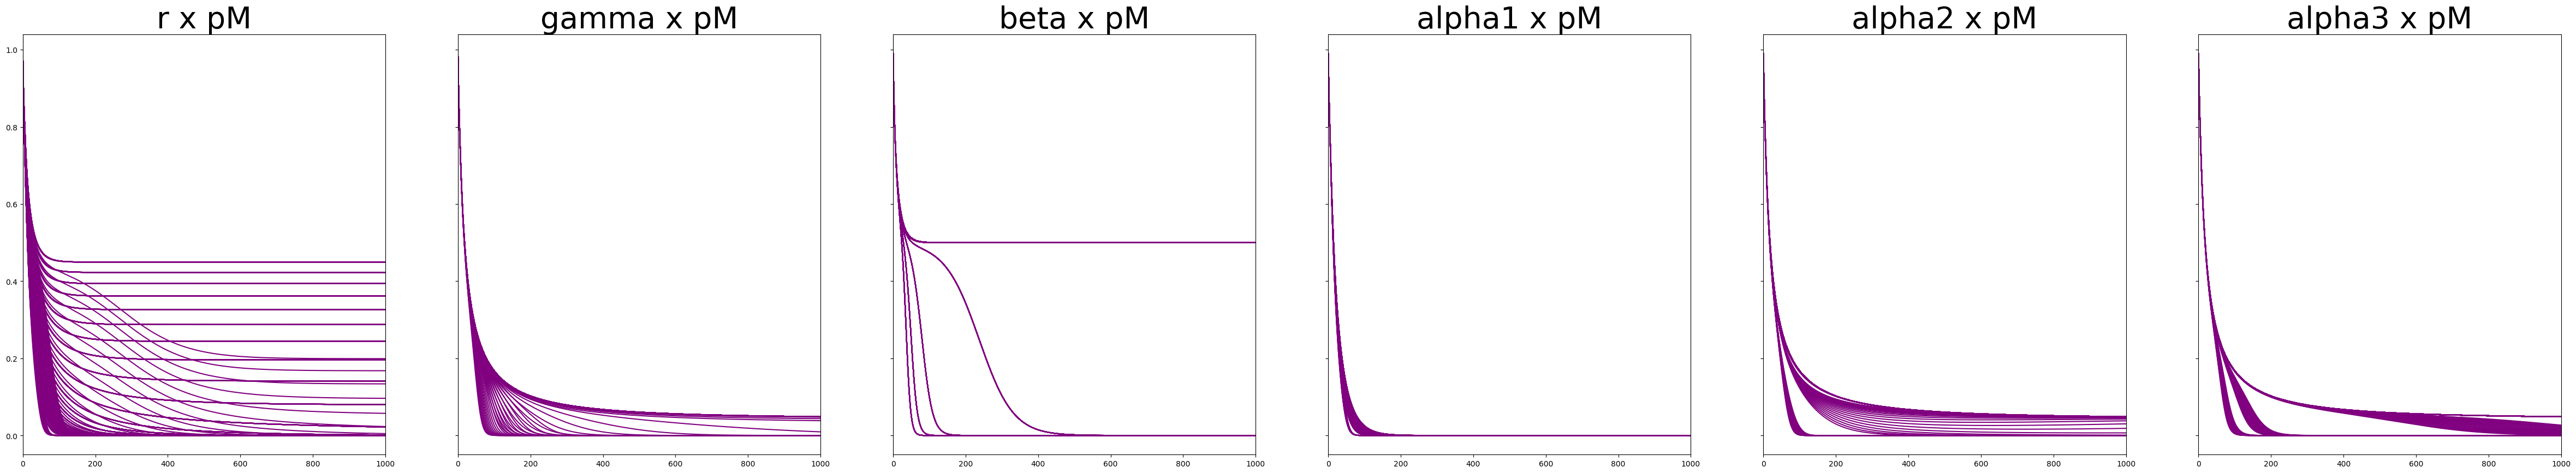

In [38]:
figure, ax = plt.subplots(ncols=6, nrows = 1, sharey=True, figsize=(60, 10))

#r x pM ---------------------------------------------------------------------------------
y = plottime(outputs_r_pM)
C_val = y[0]
C_array = y[1]

for i in C_val:
        ax[0].plot(C_array[i], c = 'purple')

ax[0].set_xlim(0,NUMYEARS)
ax[0].set_title('r x pM', fontsize = 40);

#gamma x pM ---------------------------------------------------------------------------------
y = plottime(outputs_gamma_pM)
C_val = y[0]
C_array = y[1]

for i in C_val:
        ax[1].plot(C_array[i], c = 'purple')

ax[1].set_xlim(0,NUMYEARS)
ax[1].set_title('gamma x pM', fontsize = 40);

#beta x pM ---------------------------------------------------------------------------------
y = plottime(outputs_beta_pM)
C_val = y[0]
C_array = y[1]

for i in C_val:
        ax[2].plot(C_array[i], c = 'purple')

ax[2].set_xlim(0,NUMYEARS)
ax[2].set_title('beta x pM', fontsize = 40);

#alpha1 x pM ---------------------------------------------------------------------------------
y = plottime(outputs_a1_pM)
C_val = y[0]
C_array = y[1]

for i in C_val:
        ax[3].plot(C_array[i], c = 'purple')

ax[3].set_xlim(0,NUMYEARS)
ax[3].set_title('alpha1 x pM', fontsize = 40);

#alpha2 x pM ---------------------------------------------------------------------------------
y = plottime(outputs_a2_pM)
C_val = y[0]
C_array = y[1]

for i in C_val:
        ax[4].plot(C_array[i], c = 'purple')

ax[4].set_xlim(0,NUMYEARS)
ax[4].set_title('alpha2 x pM', fontsize = 40);

#alpha3 x pM ---------------------------------------------------------------------------------
y = plottime(outputs_a3_pM)
C_val = y[0]
C_array = y[1]

for i in C_val:
        ax[5].plot(C_array[i], c = 'purple')

ax[5].set_xlim(0,NUMYEARS)
ax[5].set_title('alpha3 x pM', fontsize = 40);

# Plotting heat maps of C' across each parameter x pM combination
### This was done to estimate regions of pM parameter space at which corals can exist.

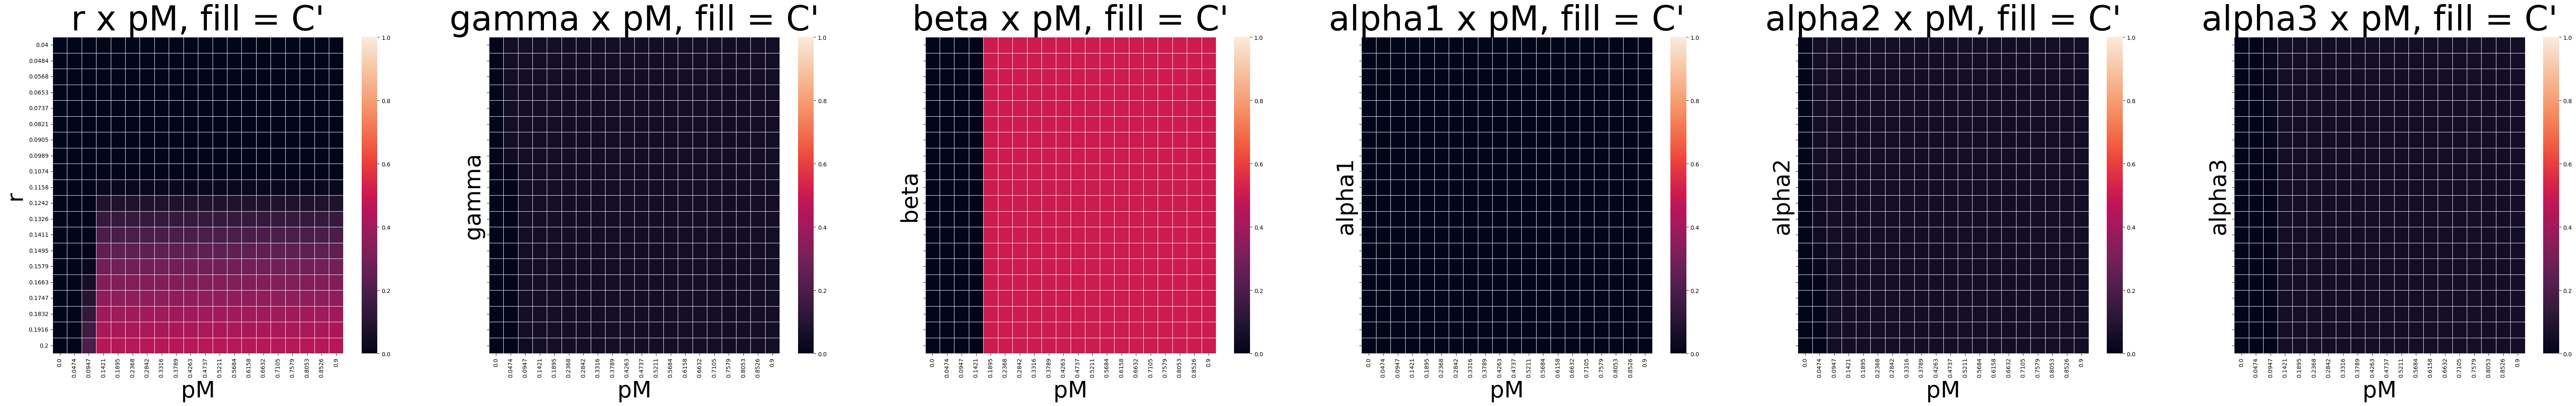

In [39]:
figure, ax = plt.subplots(ncols=6, nrows = 1, sharey=True, figsize=(80, 10))

df = outputs_r_pM[1]
heatmap = (df.pivot(index = "p1", columns = "p2", values = "C_prime"))
sns.heatmap(heatmap, vmin=0, vmax=1, annot=False, linewidths=.5, ax=ax[0])
ax[0].set_xlabel('pM', fontsize = 40)
ax[0].set_ylabel('r', fontsize = 40)
ax[0].set_title("r x pM, fill = C'", fontsize = 60);

df = outputs_gamma_pM[1]
heatmap = (df.pivot(index = "p1", columns = "p2", values = "C_prime"))
sns.heatmap(heatmap, vmin=0, vmax=1, annot=False, linewidths=.5, ax=ax[1])
ax[1].set_xlabel('pM', fontsize = 40)
ax[1].set_ylabel('gamma', fontsize = 40)
ax[1].set_title("gamma x pM, fill = C'", fontsize = 60);

df = outputs_beta_pM[1]
heatmap = (df.pivot(index = "p1", columns = "p2", values = "C_prime"))
sns.heatmap(heatmap, vmin=0, vmax=1, annot=False, linewidths=.5, ax=ax[2])
ax[2].set_xlabel('pM', fontsize = 40)
ax[2].set_ylabel('beta', fontsize = 40)
ax[2].set_title("beta x pM, fill = C'", fontsize = 60);

df = outputs_a1_pM[1]
heatmap = (df.pivot(index = "p1", columns = "p2", values = "C_prime"))
sns.heatmap(heatmap, vmin=0, vmax=1, annot=False, linewidths=.5, ax=ax[3])
ax[3].set_xlabel('pM', fontsize = 40)
ax[3].set_ylabel('alpha1', fontsize = 40)
ax[3].set_title("alpha1 x pM, fill = C'", fontsize = 60);

df = outputs_a2_pM[1]
heatmap = (df.pivot(index = "p1", columns = "p2", values = "C_prime"))
sns.heatmap(heatmap, vmin=0, vmax=1, annot=False, linewidths=.5, ax=ax[4])
ax[4].set_xlabel('pM', fontsize = 40)
ax[4].set_ylabel('alpha2', fontsize = 40)
ax[4].set_title("alpha2 x pM, fill = C'", fontsize = 60);

df = outputs_a3_pM[1]
heatmap = (df.pivot(index = "p1", columns = "p2", values = "C_prime"))
sns.heatmap(heatmap, vmin=0, vmax=1, annot=False, linewidths=.5, ax=ax[5])
ax[5].set_xlabel('pM', fontsize = 40)
ax[5].set_ylabel('alpha3', fontsize = 40)
ax[5].set_title("alpha3 x pM, fill = C'", fontsize = 60);